In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve


from imblearn.over_sampling import SMOTE

import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, AdamWeightDecay, get_linear_schedule_with_warmup

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F 
seed = 1331

In [3]:
device=torch.device('cuda:0')
torch.cuda.get_device_name(0)

'Tesla T4'

## Getting data
source: https://github.com/xliuhw/NLU-Evaluation-Data

In [4]:
!wget https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data/master/Collected-Original-Data/paraphrases_and_intents_26k_normalised_all.csv -O intent_data.csv

--2023-06-11 19:07:42--  https://raw.githubusercontent.com/xliuhw/NLU-Evaluation-Data/master/Collected-Original-Data/paraphrases_and_intents_26k_normalised_all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5151481 (4.9M) [text/plain]
Saving to: ‘intent_data.csv’

intent_data.csv     100%[===================>]   4.91M  --.-KB/s    in 0.01s   

2023-06-11 19:07:42 (334 MB/s) - ‘intent_data.csv’ saved [5151481/5151481]



## Loading data into Pandas Dataframe

In [5]:
dataframe = pd.read_csv("intent_data.csv", delimiter=";")
dataframe.head()

,answerid,answer_normalised,answer,question,scenario,intent,userid,suggested_entities
0,1,wake me up at five am this week,wake me up at 5am this week,Write what you would tell your PDA in the foll...,alarm,set,1,"date, time"
1,2,wake me up at nine am on friday,wake me up at 9am on Friday,Write what you would tell your PDA in the foll...,alarm,set,1,"date, time"
2,3,set an alarm for two hours from now,set an alarm for two hours from now,Write what you would tell your PDA in the foll...,alarm,set,1,"date, time"
3,4,cancel business meeting on wednesday,Olly cancel business meeting on wednesday,How would you ask your PDA to remove a specifi...,calendar,delete_event,1,event_name
4,5,delete the richard's wedding event next year,delete the Richard's wedding event next year,How would you ask your PDA to remove a specifi...,calendar,delete_event,1,event_name


In [6]:
unique_values = dataframe["intent"].unique()
print(unique_values)

['set' 'delete_event' 'send_email' 'query_event' 'query' 'set_event'
 'mute' 'play' 'hue' 'cleaning' 'confirmation' 'mistake' 'feedback'
 'conversation' 'taxi' 'train' 'convert' 'recipe' 'order' 'remove' 'reply'
 'preferences' 'question' 'events ' 'request' 'settings' 'locations '
 'joke' 'directions' 'factoid' 'maths' 'definition' 'movies' 'coffee'
 'confusion' 'creating' 'set_notification' 'volume' 'celebrity' 'wemo'
 'traffic' 'adding' 'open_query' 'notification' 'post' 'stock']


In [7]:
unique_values_scenario = dataframe["scenario"].unique()
print(unique_values_scenario)

['alarm' 'calendar' 'email' 'reminder' 'audio' 'podcasts' 'IOT' 'general'
 'lists' 'transport' 'datetime' 'cooking' 'takeaway' 'contacts' 'news'
 'music' 'radio' 'recommendation' 'weather' 'QA' 'social' 'audiobook'
 'game']


In [8]:
dataframe["merged"] = dataframe["scenario"] + "_" + dataframe["intent"]

In [9]:
unique_value_merged = dataframe["merged"].unique()
intent = sorted(unique_value_merged, key= lambda x : x.lower() )

In [10]:
labels = dataframe["merged"].value_counts().to_frame().reset_index()
labels.columns = ["name","count"]
labels["count"].head(10).sum()

8924

In [11]:
labels_included = labels["name"].head(12).to_list()

In [12]:
new_df = dataframe[["answer", "merged"]]

In [13]:
new_df = new_df[new_df["merged"].isin(labels_included)]

In [14]:
new_df.columns = ["speech_text","intent"]

In [15]:
import random

def train_test_split_(df, test_ratio):
    random.seed(seed)  
    indices = df.index.tolist()
    random.shuffle(indices) 
    split_index = int(len(indices) * test_ratio)
    test_indices = indices[:split_index]
    train_indices = indices[split_index:]
    train_data = df.loc[train_indices].reset_index(drop=True)
    test_data = df.loc[test_indices].reset_index(drop=True)
    return train_data, test_data




In [16]:
train_data, test_data = train_test_split_(new_df, test_ratio=0.2, )

<ipython-input-17-9c788e46f0b4>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('Set3', num_labels)


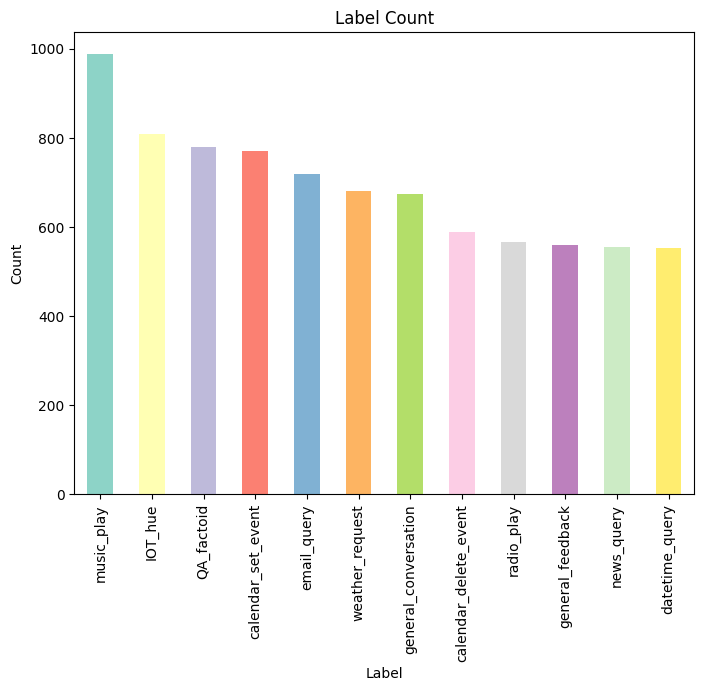

In [17]:
label_counts = train_data['intent'].value_counts()
num_labels = len(label_counts)
color_palette = plt.cm.get_cmap('Set3', num_labels)
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=color_palette(np.arange(num_labels)))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Count')
plt.show()

In [18]:
le=LabelEncoder()
train_data['intent']=le.fit_transform(train_data['intent'])
test_data['intent']=le.transform(test_data['intent'])


In [19]:
le.classes_

array(['IOT_hue', 'QA_factoid', 'calendar_delete_event',
       'calendar_set_event', 'datetime_query', 'email_query',
       'general_conversation', 'general_feedback', 'music_play',
       'news_query', 'radio_play', 'weather_request'], dtype=object)

##Bert

In [20]:
pre_trained_BERTmodel='bert-base-uncased'
BERT_tokenizer=BertTokenizerFast.from_pretrained(pre_trained_BERTmodel)

In [21]:
text= "I was on cloud nine, when I got a new project."

#Convert text to tokens & token_ids
tokens=BERT_tokenizer.tokenize(text)
token_ids=BERT_tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence : {text}')
print(f'Tokens :{tokens}')
print(f'Token IDs : {token_ids}')

Sentence : I was on cloud nine, when I got a new project.
Tokens :['i', 'was', 'on', 'cloud', 'nine', ',', 'when', 'i', 'got', 'a', 'new', 'project', '.']
Token IDs : [1045, 2001, 2006, 6112, 3157, 1010, 2043, 1045, 2288, 1037, 2047, 2622, 1012]


In [22]:
encoding=BERT_tokenizer.encode_plus(
    text,
    max_length=32,
    add_special_tokens=True,   # 'Add [SEP] & [CLS]'
    padding="max_length",
    truncation=True,
    return_attention_mask=True,  # Reurns array of 0's & 1's to distinguish padded tokens from real tokens.
    return_token_type_ids=False,
    return_tensors='pt'         # Returns pytorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [23]:
# Check input_ids
print('Maximum length of input_ids for each sentence : {}'.format(len(encoding['input_ids'][0])))
encoding['input_ids'][0]

Maximum length of input_ids for each sentence : 32


tensor([ 101, 1045, 2001, 2006, 6112, 3157, 1010, 2043, 1045, 2288, 1037, 2047,
        2622, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [24]:
print(f"Maximum length of attention mask for each sentence : {len(encoding['attention_mask'][0])}")
encoding['attention_mask'][0]

Maximum length of attention mask for each sentence : 32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
special_tokens=BERT_tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
special_tokens

['[CLS]',
 'i',
 'was',
 'on',
 'cloud',
 'nine',
 ',',
 'when',
 'i',
 'got',
 'a',
 'new',
 'project',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [26]:
token_lens=[]
for text in train_data.speech_text:
  tokens_text=BERT_tokenizer.encode(text,max_length=150,truncation=True)
  token_lens.append(len(tokens_text))

<ipython-input-27-d32ff3e56e92>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

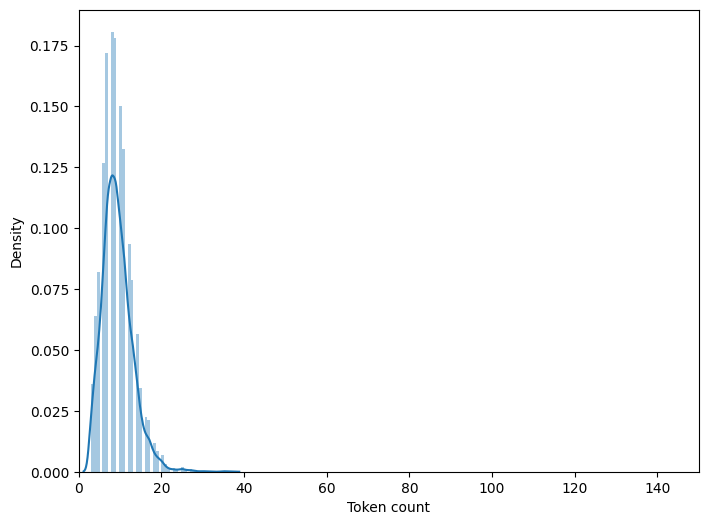

In [27]:
#Plot the tokens
plt.figure(figsize=(8,6))
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

## Create a Pytorch Dataset

In [28]:
class Speech_text_Dataset(Dataset):

  def __init__(self,text,intent,tokenizer,max_length):
    self.text=text
    self.intent=intent
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.text)

  def __getitem__(self,item):
    text = str(self.text[item])
    intent = self.intent[item]

    encoding = self.tokenizer.encode_plus(
        text,
        max_length=Max_length,
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
           
    return {
        'speech_text':text,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'intent' : torch.tensor(intent,dtype=torch.long)
    }

## let's split the train data to train and val

In [29]:
df_train,df_val=train_test_split(train_data,test_size=0.15 ,random_state=123)

print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape} ')
print(f'Testing dataset : {test_data.shape}') 
print(f'Validation dataset : {df_val.shape}')

Print the shape of datasets...
Training dataset : (7000, 2) 
Testing dataset : (2058, 2)
Validation dataset : (1236, 2)


In [30]:
batch_size=8
Max_length= 120
def data_loader(df,tokenizer, max_length, batch):
  ds=Speech_text_Dataset(
      text=df.speech_text.to_numpy(),
      intent=df.intent.to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# Load datasets
train_DataLoader=data_loader(df_train, BERT_tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(test_data, BERT_tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_val, BERT_tokenizer,Max_length,batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [31]:
BERT_data=next(iter(train_DataLoader))
BERT_data.keys()

dict_keys(['speech_text', 'input_ids', 'attention_mask', 'intent'])

In [32]:
print('Shape of the BERT_data keys...')
print(f"Input_ids : {BERT_data['input_ids'].shape}")
print(f"Attention_mask : {BERT_data['attention_mask'].shape}")
print(f"targets : {BERT_data['intent'].shape}")

Shape of the BERT_data keys...
Input_ids : torch.Size([8, 120])
Attention_mask : torch.Size([8, 120])
targets : torch.Size([8])


In [33]:
input_ids = BERT_data['input_ids'].to(device)
attention_mask = BERT_data['attention_mask'].to(device)
targets=BERT_data['intent'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 120])
torch.Size([8, 120])


In [34]:
BERT_model = BertModel.from_pretrained(pre_trained_BERTmodel)
BERT_model=BERT_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
n_classes=12

In [36]:
class BERT_SentimentClassifier(nn.Module):
   def __init__(self, n_classes):
     super(BERT_SentimentClassifier, self).__init__()
     self.bert = BertModel.from_pretrained(pre_trained_BERTmodel)
     self.drop = nn.Dropout(p=0.35)
     self.hidden=nn.Linear(self.bert.config.hidden_size,128)
     self.out = nn.Linear(128, n_classes)
     #self.softmax=nn.Softmax(dim=1)
   def forward(self, input_ids, attention_mask):
     _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,return_dict=False
    )
     output = self.drop(pooled_output)
     output=self.hidden(output)
     output=self.out(output)
     #output=self.softmax(output)
     return output

In [37]:
BERT_model = BERT_SentimentClassifier(12)
BERT_model=BERT_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
F.softmax(BERT_model(input_ids,attention_mask), dim=1).to(device)

tensor([[0.0980, 0.0787, 0.0772, 0.0611, 0.0654, 0.1354, 0.0620, 0.0718, 0.0939,
         0.0607, 0.0676, 0.1283],
        [0.0961, 0.0677, 0.0576, 0.0610, 0.0956, 0.1337, 0.0679, 0.0778, 0.0784,
         0.0891, 0.0802, 0.0949],
        [0.1177, 0.0768, 0.0541, 0.0625, 0.0680, 0.1330, 0.0542, 0.0528, 0.0887,
         0.0850, 0.0944, 0.1128],
        [0.1235, 0.0764, 0.0628, 0.0703, 0.0749, 0.0922, 0.0726, 0.0669, 0.0872,
         0.0774, 0.0842, 0.1115],
        [0.0833, 0.0720, 0.0742, 0.0569, 0.0727, 0.0945, 0.0668, 0.0704, 0.0729,
         0.0570, 0.1277, 0.1515],
        [0.1041, 0.0806, 0.0767, 0.0636, 0.0775, 0.1343, 0.0625, 0.0598, 0.0685,
         0.0960, 0.0881, 0.0882],
        [0.0978, 0.0744, 0.0688, 0.0747, 0.0685, 0.1136, 0.0604, 0.0698, 0.0925,
         0.0841, 0.0791, 0.1162],
        [0.0936, 0.0815, 0.0814, 0.0625, 0.0619, 0.1249, 0.0702, 0.0578, 0.0868,
         0.0673, 0.0852, 0.1269]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [39]:

BERT_model

BERT_SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [40]:
epochs=5
optimizer=AdamW(BERT_model.parameters(),lr=2e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [41]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["intent"].to(device)
    #Feed data to BERT model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    torch.autograd.set_detect_anomaly(True)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_observations, np.mean(losses)

In [42]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["intent"].to(device)
      # Feed data to BERT model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_observations, np.mean(losses)

In [43]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 10)
  train_acc, train_loss = train(
    BERT_model,
    train_DataLoader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    BERT_model,
    valid_DataLoader,
    device,
    loss_fn,
    len(df_val)
  )
  print(f'Validation  loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(BERT_model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.5915784578344652 accuracy 0.8465714285714286
Validation  loss 0.3409481156437147 accuracy 0.9215210355987056

Epoch 2/5
----------
Train loss 0.23459517253908727 accuracy 0.9477142857142857
Validation  loss 0.3774413005148451 accuracy 0.9231391585760518

Epoch 3/5
----------
Train loss 0.15322519287440395 accuracy 0.9675714285714286
Validation  loss 0.3870594397052041 accuracy 0.9231391585760518

Epoch 4/5
----------
Train loss 0.11193277571323727 accuracy 0.9757142857142858
Validation  loss 0.3665888480323878 accuracy 0.9312297734627832

Epoch 5/5
----------
Train loss 0.08708757237471373 accuracy 0.980857142857143
Validation  loss 0.37787710940540437 accuracy 0.93042071197411

CPU times: user 32min 39s, sys: 2min 50s, total: 35min 29s
Wall time: 36min 9s
